# Nonreciprocity in the system of two transmons

Computing nonreciprocity in the system of two superconducting qubits (transmons).

We compare two different approaches:
- Taking into account higher levels: we use the Hamiltonian expanded into Taylor series upto 4th power.
- Conventional approach with two qubits

In [2]:
import qutip as qt
import numpy as np
import qucat as qc
import scipy as sc
import matplotlib.pyplot as plt

 ## System parameters

In [486]:
N_excitations = 5
N_qubits = 2
DIM = N_excitations**N_qubits
NMAX = 50
DIRECTION = 'R'

# Field parameters
a_mag = 0.005*np.sqrt(1.5e+9)
if DIRECTION == 'R':
    a_R = a_mag
    a_L = 0e-2
elif DIRECTION == 'L':
    a_R = 0e-2
    a_L = a_mag
a_inc = {'R': a_R, 'L': a_L}

L_js = [3.15e-9, 3.3e-9]

In [487]:
# intial state
psi0 = qt.basis(N_excitations, 0) # start without excitations
for j in range(N_qubits - 1):
    psi0 = qt.tensor(psi0, qt.basis(N_excitations, 0))
rho0 = qt.ket2dm(psi0)

# transition operators
a_ops = [qt.destroy(N_excitations) if i==0 else qt.qeye(N_excitations) for i in range(N_qubits)]

for i in range(N_qubits):
    for j in range(1, N_qubits):
        if i==j:
            j_op = qt.destroy(N_excitations)
        else: 
            j_op = qt.qeye(N_excitations)
            
        a_ops[i] = qt.tensor(a_ops[i], j_op)
        
# unity operator        
i_op = qt.qeye(N_excitations)
for j in range(1, N_qubits):
    i_op = qt.tensor(i_op, qt.qeye(N_excitations))

### Using qucat for transmons

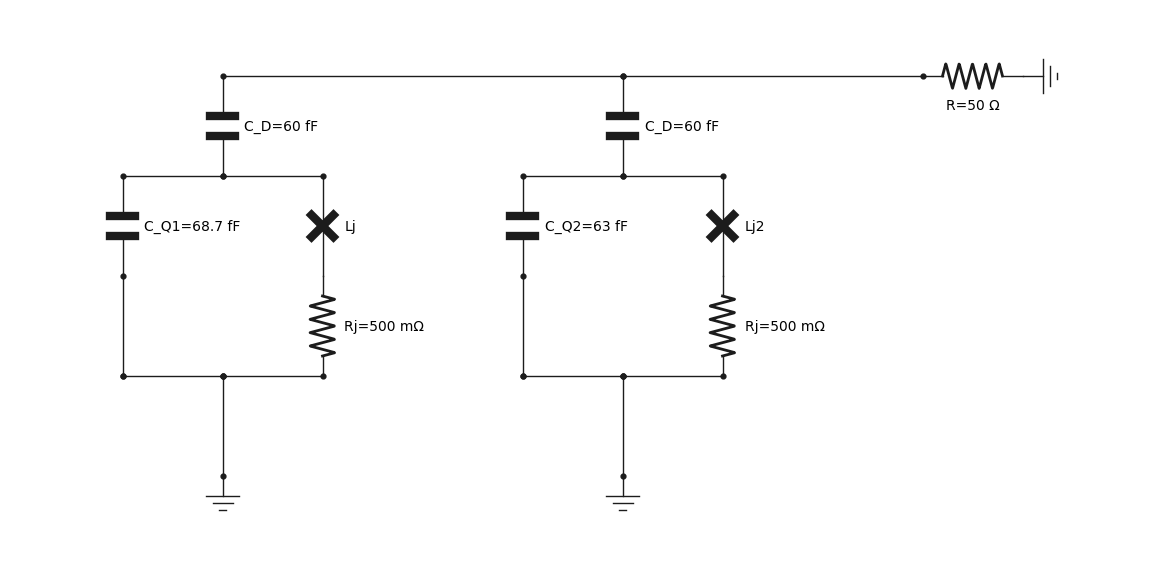

C 0 3 C_D=60 fF
C 0 1 C_Q1=68.7 fF
C 2 3 C_D=60 fF
J 0 4 Lj
C 1 2 C_Q2=63 fF
J 2 5 Lj2
R 1 3 R=50 Ohm
R 1 4 Rj=500 mOhm
R 1 5 Rj=500 mOhm




In [488]:
cir = qc.GUI('circuits/basics.txt', # location of the circuit file
        edit=False, # open the GUI to edit the circuit
        plot=True, # plot the circuit after having edited it
        print_network=True # print the network
       )
cirs = [cir]

In [489]:
cir.f_k_A_chi(pretty_print=True, Lj=L_js[0], Lj2=L_js[1])

         mode |       freq.  |       diss.  |       anha.  |
            0 |      7.9 GHz |     24.7 MHz |       77 MHz |
            1 |     7.97 GHz |     1.15 GHz |     87.5 MHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |       77 MHz |              |
            1 |      164 MHz |     87.5 MHz |



(array([7.90261980e+09, 7.97073589e+09]),
 array([2.47292015e+07, 1.14526952e+09]),
 array([76978465.99110788, 87479103.24479595]),
 array([[7.69784660e+07, 1.63996457e+08],
        [1.63996457e+08, 8.74791032e+07]]))

In [490]:
# Compute hamiltonian (for h=1, so all energies are expressed in frequency units, not angular)
H_tr = 2.0*np.pi*cir.hamiltonian(
    #modes = [0,1],# Include modes 0 and 1
    taylor = 4,# Taylor the Josephson potential to the power 4
    excitations = N_excitations,
    Lj = L_js[0], Lj2=L_js[1])# set any component values that were not fixed when building the circuit


# QuTiP method which return the eigenergies of the system
ee = H_tr.eigenenergies()

In [491]:
# transitions in GHz
np.array([ee[j+1] - ee[j] for j in range(N_excitations-1)])/(2*np.pi/1e-9)

array([7.73636517, 0.05788242, 7.53975315, 0.02545839])

In [492]:
H_tr

Quantum object: dims = [[5, 5], [5, 5]], shape = (25, 25), type = oper, isherm = True
Qobj data =
[[-5.15934378e+08+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -7.52897026e+08-7.14409318e+06j  0.00000000e+00+0.00000000e+00j
  -2.24309759e+08-4.17303238e+06j  0.00000000e+00+0.00000000e+00j
  -2.53570172e+07-7.08848177e+04j  0.00000000e+00+0.00000000e+00j
  -1.89464201e+07+4.09507241e+06j  0.00000000e+00+0.00000000e+00j
  -7.06243616e+08+7.07466937e+06j  0.00000000e+00+0.00000000e+00j
  -5.15210054e+08+7.08797717e+04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.83955469e+06-4.11285905e+06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.97376180e+08+4.03501159e+06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  4.85008188e+10+0.00000000e+00j
   0.0000

(None, <Axes: >)

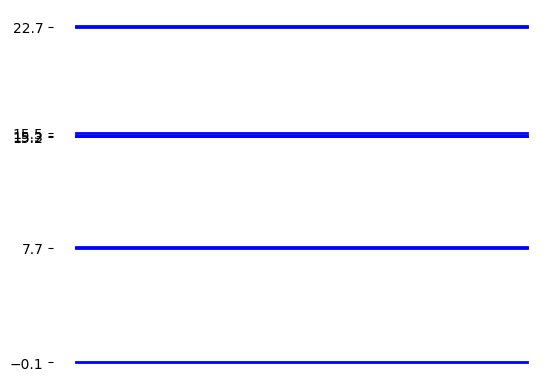

In [493]:
fig_energy, ax = plt.subplots(1, 1)
qt.plot_energy_levels([H_tr/(2*np.pi*1e9)], N=8, ax=ax, show_ylabels=True)

In [494]:
def cir_parameters_norm_modes(cir, L_j, a_inc):
    gammas = 2.0*np.pi*cir.loss_rates(Lj = L_j[0], Lj2 = L_j[1])
    chi = 2.0*np.pi*cir.kerr(Lj = L_j[0], Lj2 = L_j[1])
    np.fill_diagonal(chi, 0)
    w_m = 2.0*np.pi*cir.eigenfrequencies(Lj = L_j[0], Lj2 = L_j[1])
    w_ext = w_m[0]
    delta = (w_m[0] - w_m[1]) / np.mean(gammas)
    t_j = np.array([0.0, (np.pi - delta) / w_ext])
    t_ij = np.array([[t_j[i] - t_j[j] for j in range(len(t_j))] for i in range(len(t_j))])
    return {
        'a_inc': a_inc,
        'w_m': 2.0*np.pi*cir.eigenfrequencies(Lj = L_j[0], Lj2 = L_j[1]),
        'w_ext': w_ext,
        'A_m': 2.0*np.pi*cir.anharmonicities(Lj = L_j[0], Lj2 = L_j[1]),
        'gammas': gammas,
        'gamma_nr': 190.0e3 * 2.0*np.pi,
        'gamma_phi': 200.0e3 * 2.0*np.pi,
        'delta': delta,
        'chi_mn': chi,
        't_j': t_j,
        't_ij': t_ij,
        'Omega_R': np.array([1.0j*np.sqrt(0.5*gammas[j])*
                      (a_inc['R'] * np.exp(-1j * w_ext * t_j[j]) + 
                       a_inc['L'] * np.exp(1j * w_ext * t_j[j])) 
                      for j in range(len(w_m))]),
        'Omega': np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                       np.sin(w_ext * np.abs(t_ij[i,j]))
                       for j in range(len(w_m))] 
                      for i in range(len(w_m))]),
        'Gamma': np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                       np.cos(w_ext * np.abs(t_ij[i,j]))
                       for j in range(len(w_m))] 
                      for i in range(len(w_m))]),
        # output operators
        'out_ops': {'R': a_inc['R']*i_op + sum([np.exp(-1j*w_m[j]*t_j[j])*
                                             np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(w_m))]),
                    'L': a_inc['L']*i_op + sum([np.exp(1j*w_m[j]*t_j[j])*
                                             np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(w_m))])},
        # for non-rotating frame, a_in * exp(-i w_ext t) as an input signal
        'out_ops_t': {'R': sum([np.exp(-1j*w_m[j]*t_j[j])*
                                             np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(w_m))]),
                      'L': sum([np.exp(1j*w_m[j]*t_j[j])*
                                             np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(w_m))])}
        }


def cir_parameters(cirs, L_js, a_inc):
    gammas = 2.0*np.pi*np.array([cirs[i].loss_rates(Lj = L_js[i])[0] for i in range(len(cirs))])
    w_m = 2.0*np.pi*np.array([cirs[i].eigenfrequencies(Lj = L_js[i])[0] for i in range(len(cirs))])
    w_ext = w_m[0]
    delta = (w_m[0] - w_m[1]) / np.mean(gammas)
    t_j = np.array([0.0, (np.pi - delta) / w_ext])
    t_ij = np.array([[t_j[i] - t_j[j] for j in range(len(cirs))] for i in range(len(cirs))])
    return {
    'w_m': w_m,
    'w_ext': w_ext,
    'A_m': 2.0*np.pi*np.array([cirs[i].anharmonicities(Lj = L_js[i])[0] for i in range(len(cirs))]),
    'gammas': gammas,
    'gamma_nr': 190.0e3 * 2.0*np.pi,
    'gamma_phi': 200.0e3 * 2.0*np.pi,
    'delta': delta,
    't_j': t_j,
    't_ij': t_ij,
    'Omega_R': np.array([1.0j*np.sqrt(0.5*gammas[j])*
                  (a_inc['R'] * np.exp(-1j * w_ext * t_j[j]) + 
                   a_inc['L'] * np.exp(1j * w_ext * t_j[j])) 
                  for j in range(len(cirs))]),
    'Omega': np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                   np.sin(w_ext * np.abs(t_ij[i,j]))
                   for j in range(len(cirs))] 
                  for i in range(len(cirs))]),
    'Gamma': np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                   np.cos(w_ext * np.abs(t_ij[i,j]))
                   for j in range(len(cirs))] 
                  for i in range(len(cirs))]),
    # output operators
    'out_ops': {'R': a_inc['R']*i_op + sum([np.exp(-1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))]),
                'L': a_inc['L']*i_op + sum([np.exp(1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))])},
    # for non-rotating frame, a_in * exp(-i w_ext t) as an input signal
    'out_ops_t': {'R': sum([np.exp(-1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))]),
                  'L': sum([np.exp(1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))])}
    }

In [495]:
a_inc

{'R': 193.64916731037084, 'L': 0.0}

In [496]:
p = cir_parameters_norm_modes(cir, L_js, a_inc)
out_ops = p['out_ops']

In [497]:
p["gamma_phi"]/np.mean(p["gammas"])

0.0003418807168115309

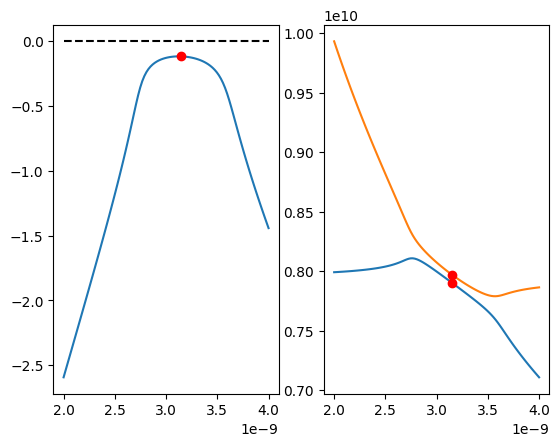

In [498]:
L_j_list = np.linspace(2e-9, 4e-9, 100)

fig_par, ax = plt.subplots(1, 2)
ax[0].plot(L_j_list, np.array([cir_parameters_norm_modes(cir, [j, L_js[1]], a_inc)['delta'] for j in L_j_list]), 
       label='delta')
ax[0].plot(L_j_list, np.array([0.0 for j in L_j_list]), '--', color='black')
ax[0].plot(L_js[0], cir_parameters_norm_modes(cir, L_js, a_inc)['delta'], 'o', color='r')
ax[1].plot(L_j_list, np.array([cir.eigenfrequencies(Lj=j, Lj2=L_js[1]) for j in L_j_list]))
ax[1].plot([L_js[0], L_js[0]], cir.eigenfrequencies(Lj=L_js[0], Lj2=L_js[1]), 'o', color='r')


## Hamiltonian and Liouvillian

In [499]:
# For 2 separate qubits

def hamiltonian_transmon(parameters):
    p = parameters
    
    H_0 = sum([(p['w_m'][j] - p['w_ext'])*a_ops[j].dag()*a_ops[j] 
               - 0.5*p['A_m'][j]*a_ops[j].dag()*a_ops[j].dag()*a_ops[j]*a_ops[j]#(a_ops[j].dag() + a_ops[j])**4
               for j in range(N_qubits)])
    H_f = sum([p['Omega_R'][j]*a_ops[j] + np.conj(p['Omega_R'][j])*a_ops[j].dag() for j in range(N_qubits)])
    H_d = sum(sum([[p['Omega'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    return H_0 + H_f + H_d, H_0, H_f, H_d


def hamiltonian_transmon_time_drive(args):
    p = args
    H_0 = sum([(p['w_m'][j] - p['w_ext'])*a_ops[j].dag()*a_ops[j] 
               - 0.5*p['A_m'][j]*a_ops[j].dag()*a_ops[j].dag()*a_ops[j]*a_ops[j]#(a_ops[j].dag() + a_ops[j])**4
               for j in range(N_qubits)])
    H_d = sum(sum([[p['Omega'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    time_dep_coeff_m = [
        f'-2.0*sqrt(0.5*g[{j}])*sqrt(w_ext/w[{j}]) * \
        (a_L*sin(w_ext*(t+t_j[{j}])) + a_R*sin(w_ext*(t-t_j[{j}]))) * \
        exp(-1j*w_ext*t)'
        for j in range(N_qubits)
        ]
    time_dep_coeff_p = [
        f'-2.0*sqrt(0.5*g[{j}])*sqrt(w_ext/w[{j}]) * \
        (a_L*sin(w_ext*(t+t_j[{j}])) + a_R*sin(w_ext*(t-t_j[{j}]))) * \
        exp(1j*w_ext*t)'
        for j in range(N_qubits)
        ]
    H = [H_0, H_d,
        *[ [a_ops[i], time_dep_coeff_m[i]] for i in range(N_qubits) ],
        *[ [a_ops[i].dag(), time_dep_coeff_p[i]] for i in range(N_qubits) ]
        ]
    arguments_dict = {
        f'g': p['gammas'],
        'w_ext': p['w_ext'],
        f'w': p['w_m'],
        'a_L': p['a_inc']['L'],
        f't_j': p['t_j'],
        'a_R': p['a_inc']['R']
    }
    return H, arguments_dict


def hamiltonian_transmon_time_drive_nonrotating(args):
    p = args
    H_0 = sum([(p['w_m'][j])*a_ops[j].dag()*a_ops[j] 
               - 1.0/12.0*p['A_m'][j]*(a_ops[j].dag() + a_ops[j])**4
               for j in range(N_qubits)])
    H_d = sum(sum([[p['Omega'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    time_dep_coeff = [
        f'-2.0*sqrt(0.5*g[{j}])*sqrt(w_ext/w[{j}]) * \
        (a_L*sin(w_ext*(t+t_j[{j}])) + a_R*sin(w_ext*(t-t_j[{j}])))'
        for j in range(N_qubits)
        ]
    H = [H_0, H_d,
        *[ [(a_ops[i] + a_ops[i].dag()), time_dep_coeff[i]] for i in range(N_qubits) ]
        ]
    arguments_dict = {
        f'g': p['gammas'],
        'w_ext': p['w_ext'],
        f'w': p['w_m'],
        'a_L': p['a_inc']['L'],
        f't_j': p['t_j'],
        'a_R': p['a_inc']['R']
    }
    return H, arguments_dict



In [500]:
# For two combined

def hamiltonian_transmon_norm_modes(H_tr, parameters):
    p = parameters
    
    H_0 = H_tr + sum([(- p['w_ext'])*a_ops[j].dag()*a_ops[j] for j in range(N_qubits)])
    H_f = sum([p['Omega_R'][j]*a_ops[j] + np.conj(p['Omega_R'][j])*a_ops[j].dag() for j in range(N_qubits)])
    H_d = sum(sum([[p['Omega'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    return H_0 + H_f + H_d, H_0, H_f, H_d


def hamiltonian_transmon_time_drive_nonrotating_norm_modes(H_tr, args):
    p = args
    H_0 = H_tr
    H_d = sum(sum([[p['Omega'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    time_dep_coeff = [
        f'-2.0*sqrt(0.5*g[{j}])*sqrt(w_ext/w[{j}]) * \
        (a_L*sin(w_ext*(t+t_j[{j}])) + a_R*sin(w_ext*(t-t_j[{j}])))'
        for j in range(N_qubits)
        ]
    H = [H_0, H_d,
        *[ [(a_ops[i] + a_ops[i].dag()), time_dep_coeff[i]] for i in range(N_qubits) ]
        ]
    arguments_dict = {
        f'g': p['gammas'],
        'w_ext': p['w_ext'],
        f'w': p['w_m'],
        'a_L': p['a_inc']['L'],
        f't_j': p['t_j'],
        'a_R': p['a_inc']['R']
    }
    return H, arguments_dict


def jump_operators(a_ops, args):
    J_ops = []
    Gamma = args["Gamma"]
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [ np.sqrt(2*lam[i])*sum([b[j, i] * a_ops[j] for j in range(N_qubits) ]) for i in range(N_qubits)]
    return J_ops

In [501]:
def transmission(direction: str, rho, a_inc):
    return qt.expect(out_ops[direction].dag()*out_ops[direction], 
                     rho) / np.abs(a_inc)**2


def transmission_f(direction: str, rho, a_inc):
    return np.abs(qt.expect(out_ops[direction], rho) / a_inc)

In [502]:
H, H_0, H_f, H_i = hamiltonian_transmon_norm_modes(H_tr, p)
L_diss = sum([sum([2*p['Gamma'][i,j]*qt.lindblad_dissipator(a_ops[i], a_ops[j]) 
                   for j in range(N_qubits)]) for i in range(N_qubits)])
c_ops_nr = [np.sqrt(p["gamma_nr"]) * a_ops[j] for j in range(len(a_ops))]
c_ops_deph = [np.sqrt(p["gamma_phi"]) * (a_ops[j].dag()*a_ops[j] - a_ops[j]*a_ops[j].dag()) for j in range(len(a_ops))]
L_0 = qt.liouvillian(H, c_ops=c_ops_nr + c_ops_deph)
L = L_0 + L_diss

In [503]:
H_t, H_args = hamiltonian_transmon_time_drive_nonrotating_norm_modes(H_tr, p)

(<Figure size 800x400 with 1 Axes>, <Axes: >)

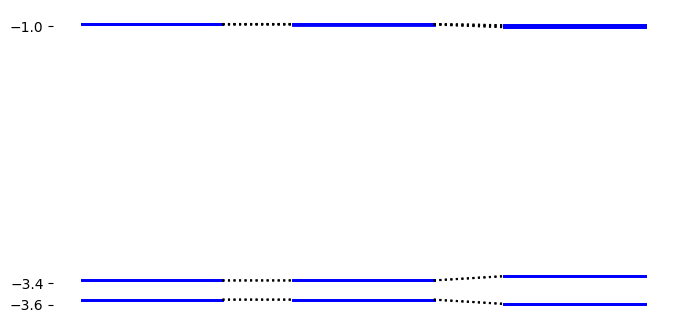

In [504]:
qt.plot_energy_levels([H_0/(2*np.pi*1e9), H_f/(2*np.pi*1e9), H_i/(2*np.pi*1e9)], N=8, figsize=(8, 4), show_ylabels=True)

In [505]:
L

Quantum object: dims = [[[5, 5], [5, 5]], [[5, 5], [5, 5]]], shape = (625, 625), type = super, isherm = False
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j -1.15370217e+07+1.34945040e+06j
  -7.14409318e+06+7.52897026e+08j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 1.15370217e+07+1.34945040e+06j -3.59856720e+09+6.36871489e+08j
  -1.63158126e+07+1.90841106e+06j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 7.14409318e+06+7.52897026e+08j  1.63158126e+07+1.90841106e+06j
  -7.19713440e+09+1.82339039e+09j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ... -2.22333990e+10+2.39023558e+09j
  -1.99827078e+07+2.33731666e+06j -4.78623235e+07+4.99703078e+09j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e

## Time evolution

In [506]:
# ODE solver options
opts = qt.Options(atol=1e-16, rtol=1e-14, method='adams', order=12, nsteps=10000, first_step=0, max_step=0, 
        min_step=0, average_expect=True, average_states=False, tidy=True, num_cpus=0, norm_tol=0.001, 
        norm_t_tol=1e-06, norm_steps=5, rhs_reuse=False, rhs_filename=None, ntraj=500, gui=False, 
        rhs_with_state=False, store_final_state=False, store_states=False, steady_state_average=False, 
        seeds=None, normalize_output=True, use_openmp=None, openmp_threads=None)


In [507]:
w = np.real(sc.linalg.eigvals(p['Gamma']))

In [508]:
tlist = np.linspace(0.0, 1e0/np.min(w), 200)
rho_ss = qt.steadystate(L, method='direct', maxiter=1e9, tol=1e-24, use_precond=True)
result_t = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[], options=qt.Options(nsteps=1e7))
J_ops = jump_operators(a_ops, p)
result_tt = qt.mesolve(H_t, rho0, tlist, c_ops=J_ops + c_ops_nr + c_ops_deph, e_ops=[], args=H_args, 
                       options=qt.Options(nsteps=1e7, rhs_reuse=False))

In [509]:
rho_ss.tr()

1.0000000000000009

In [510]:
print(transmission_f(DIRECTION, rho_ss, a_inc[DIRECTION]), 
      transmission_f(DIRECTION, result_t.states[-1], a_inc[DIRECTION]),
      transmission_f(DIRECTION, result_tt.states[-1], a_inc[DIRECTION]))

0.6067290941336947 0.6067289690012055 1.8004731314378515


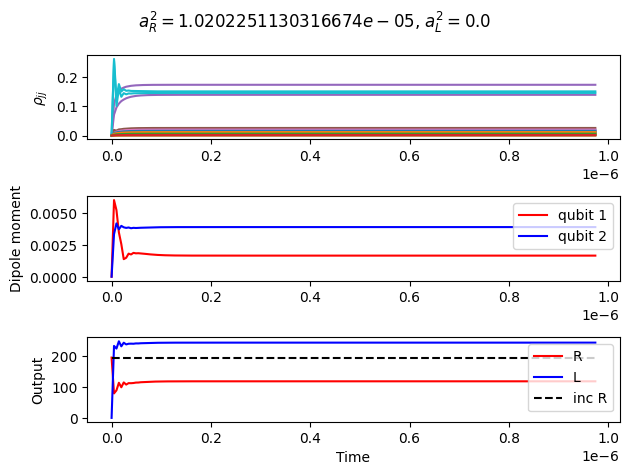

In [511]:
fig_0, ax = plt.subplots(3, 1)
ax[0].plot(tlist, [result_t.states[i].diag()[1:DIM] for i in range(len(tlist))])
ax[0].set_ylabel(r'$\rho_{jj}$')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[0], result_t.states)), color='r', label='qubit 1')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[1], result_t.states)), color='b', label='qubit 2')
ax[1].set_ylabel('Dipole moment')
ax[1].legend()
ax[2].plot(tlist, np.abs(qt.expect(out_ops['R'], result_t.states)), color='r', label='R')
ax[2].plot(tlist, np.abs(qt.expect(out_ops['L'], result_t.states)), color='b', label='L')
ax[2].plot(tlist, [np.abs(a_inc[DIRECTION]) for i in tlist], '--', color='black', 
           label='inc '+ DIRECTION)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Output')
ax[2].legend()
fig_0.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_0.tight_layout()

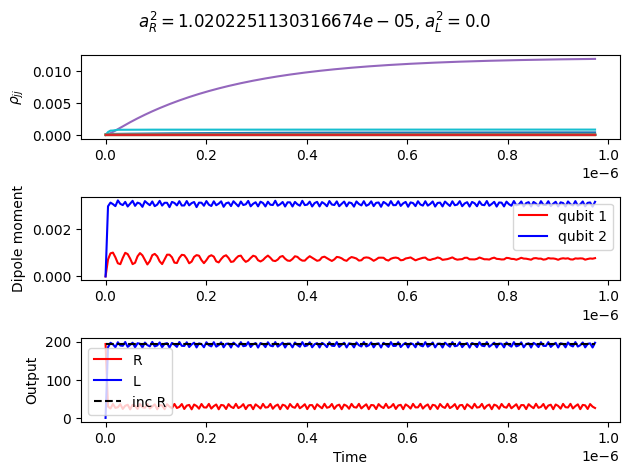

In [512]:
fig_0, ax = plt.subplots(3, 1)
ax[0].plot(tlist, [result_tt.states[i].diag()[1:DIM] for i in range(len(tlist))])
ax[0].set_ylabel(r'$\rho_{jj}$')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[0], result_tt.states)), color='r', label='qubit 1')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[1], result_tt.states)), color='b', label='qubit 2')
ax[1].set_ylabel('Dipole moment')
ax[1].legend()
ax[2].plot(tlist, np.abs(qt.expect(p['out_ops_t']['R'], result_tt.states) + a_inc['R']*np.exp(-1j*p['w_ext']*tlist)) , color='r', label='R')
ax[2].plot(tlist, np.abs(qt.expect(p['out_ops_t']['L'], result_tt.states) + a_inc['L']*np.exp(-1j*p['w_ext']*tlist)), color='b', label='L')
ax[2].plot(tlist, [np.abs(a_inc[DIRECTION]) for i in tlist], '--', color='black', 
           label='inc '+ DIRECTION)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Output')
ax[2].legend()
fig_0.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_0.tight_layout()

In [513]:
np.abs(qt.expect((p['out_ops_t']['R'] + a_inc['R']*np.exp(-1j*p['w_ext']*tlist[-1])), result_tt.states[-1]))**2 / a_mag**2

0.017948545551230138

## Incident power dependence

In [514]:
def transmission_power_dependence(a_in, L_j1, L_j2, direction: str = 'R'):
    if direction == 'R':
        a_inc = {'R': a_in, 'L': 0.0}
    elif direction == 'L':
        a_inc = {'R': 0.0, 'L': a_in}
    L_js = [L_j1, L_j2]
    p = cir_parameters_norm_modes(cir, L_js, a_inc)
    w = np.real(sc.linalg.eigvals(p['Gamma']))
    out_ops_t = p['out_ops_t']
    
    H_tr = 2.0*np.pi*cir.hamiltonian(
        #modes = [0,1],# Include modes 0 and 1
        taylor = 4,# Taylor the Josephson potential to the power 4
        excitations = N_excitations,
        Lj = L_js[0], Lj2=L_js[1])# set any component values that were not fixed when building the circuit

    
    H, H_args = hamiltonian_transmon_time_drive_nonrotating_norm_modes(H_tr, p)

    c_ops_nr = [np.sqrt(p["gamma_nr"]) * a_ops[j] for j in range(len(a_ops))]
    c_ops_deph = [np.sqrt(p["gamma_phi"]) * (a_ops[j].dag()*a_ops[j] - a_ops[j]*a_ops[j].dag()) 
                  for j in range(len(a_ops))]
    J_ops = jump_operators(a_ops, p)

    tlist = np.linspace(0.0, 1e0/np.min(w), 200)
    result_tt = qt.mesolve(H, rho0, tlist, c_ops=J_ops + c_ops_nr + c_ops_deph, e_ops=[], args=H_args, 
                           options=qt.Options(nsteps=1e7, rhs_reuse=False))
    
    rho_ss = result_tt.states[-1]
    output = a_inc[direction]*np.exp(-1j*p['w_ext']*tlist[-1]) + out_ops_t[direction]
    return (np.abs(qt.expect(output, rho_ss))**2 / np.abs(a_inc[direction])**2)  # intensity transmission
    #return np.abs(qt.expect(out_ops[direction], rho_ss) / a_inc[direction])

In [515]:
transmission_power_dependence(a_mag, 3.15e-9, 3.3e-9, direction='R')

0.017948545551230138

In [516]:
a_mag**2 / np.mean(p['gammas'])

1.0202251130316674e-05

In [517]:
a_inc_list = 10.0**np.linspace(-6, 1, 20)*np.sqrt(1.5e+9)  # field amplitudes
L_j1_list = 3.15e-9
L_j2_list = 3.3e-9

transmission_R = np.array(qt.parallel_map(transmission_power_dependence, 
                                          a_inc_list, task_args=(L_j1_list, L_j2_list, ),
                                          task_kwargs=dict(direction='R'),
                                          progress_bar=True))
transmission_L = np.array(qt.parallel_map(transmission_power_dependence, 
                                          a_inc_list, task_args=(L_j1_list, L_j2_list, ),  
                                          task_kwargs=dict(direction='L'),
                                          progress_bar=True))
efficiency = (transmission_L*np.abs((transmission_L - transmission_R) /
                         (transmission_L + transmission_R)))
cir_parameters_norm_modes(cir, [L_j1_list, L_j2_list], a_inc)['delta']

10.0%. Run time: 228.54s. Est. time left: 00:00:34:16
20.0%. Run time: 228.68s. Est. time left: 00:00:15:14
30.0%. Run time: 228.80s. Est. time left: 00:00:08:53
40.0%. Run time: 228.87s. Est. time left: 00:00:05:43
50.0%. Run time: 484.84s. Est. time left: 00:00:08:04
60.0%. Run time: 485.17s. Est. time left: 00:00:05:23
70.0%. Run time: 485.61s. Est. time left: 00:00:03:28
80.0%. Run time: 486.13s. Est. time left: 00:00:02:01
90.0%. Run time: 622.09s. Est. time left: 00:00:01:09
100.0%. Run time: 651.03s. Est. time left: 00:00:00:00
Total run time: 651.06s
10.0%. Run time: 223.51s. Est. time left: 00:00:33:31
20.0%. Run time: 223.58s. Est. time left: 00:00:14:54
30.0%. Run time: 223.96s. Est. time left: 00:00:08:42
40.0%. Run time: 224.02s. Est. time left: 00:00:05:36
50.0%. Run time: 678.73s. Est. time left: 00:00:11:18
60.0%. Run time: 679.02s. Est. time left: 00:00:07:32
70.0%. Run time: 679.25s. Est. time left: 00:00:04:51
80.0%. Run time: 679.62s. Est. time left: 00:00:02:49
90.

-0.11643788173968689

In [918]:
cir_parameters_norm_modes(cir, [L_j1_list, L_j2_list], a_inc)

{'w_m': array([4.95609567e+10, 4.96359944e+10]),
 'w_ext': 49560956733.84783,
 'A_m': array([9.89938466e+08, 9.89939839e+08]),
 'gammas': array([5.10511276e+08, 5.12058302e+08]),
 'gamma_nr': 1193805.2083641214,
 'gamma_phi': 1256637.0614359172,
 'delta': -0.1467630516041133,
 't_j': array([0.00000000e+00, 6.63497221e-11]),
 't_ij': array([[ 0.00000000e+00, -6.63497221e-11],
        [ 6.63497221e-11,  0.00000000e+00]]),
 'Omega_R': array([      0.        +61877577.28074521j,
        9062476.15378696-61305047.04047008j]),
 'Omega': array([[        0.        , -37384271.23739091],
        [-37384271.23739091,         0.        ]]),
 'Gamma': array([[ 2.55255638e+08, -2.52893852e+08],
        [-2.52893852e+08,  2.56029151e+08]]),
 'out_ops': {'R': Quantum object: dims = [[5, 5], [5, 5]], shape = (25, 25), type = oper, isherm = False
  Qobj data =
  [[     0.           +0.j         -15817.04910878+2418.69977509j
         0.           +0.j              0.           +0.j
         0.         

In [287]:
np.max(efficiency)

0.0

In [518]:
transmission_R

array([0.01794812, 0.01794812, 0.01794812, 0.01794812, 0.01794812,
       0.01794812, 0.01794812, 0.01794812, 0.01794813, 0.01794819,
       0.01794852, 0.01795028, 0.01795951, 0.01799878, 0.01823046,
       0.01983268, 0.02838359, 0.06752401, 0.55149876, 0.93856669])

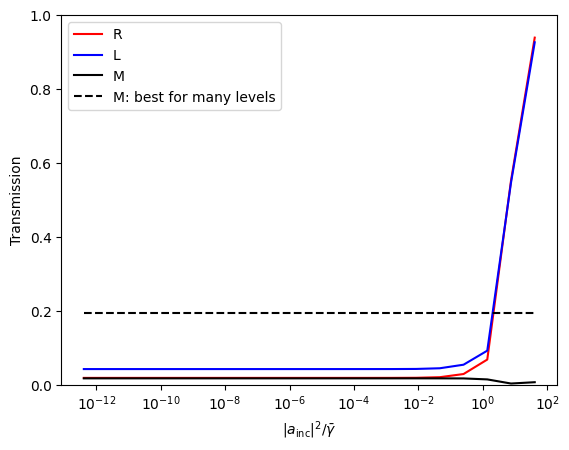

In [519]:
fig_1, ax = plt.subplots(1, 1)

p_for_plot = cir_parameters_norm_modes(cir, [L_j1_list, L_j2_list], a_inc)

ax.plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), transmission_R, color='r', label='R')
ax.plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), transmission_L, color='b', label='L')
ax.plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), efficiency, color='black', label='M')
ax.plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), [0.19438318739140012 for j in a_inc_list], '--',color='black', label='M: best for many levels')
ax.set_xscale('log')
ax.set_xlabel(r'$|a_\mathrm{inc}|^2 / \bar{\gamma}$')
ax.set_ylabel('Transmission')
ax.set_ylim(0,1)
ax.legend()

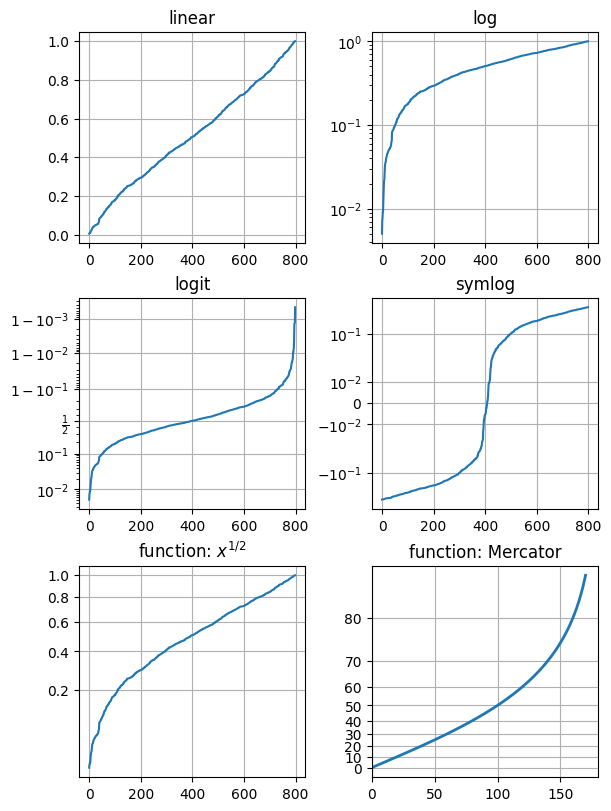

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator

# Fixing random state for reproducibility
np.random.seed(19680801)

# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
fig, axs = plt.subplots(3, 2, figsize=(6, 8), layout='constrained')

# linear
ax = axs[0, 0]
ax.plot(x, y)
ax.set_yscale('linear')
ax.set_title('linear')
ax.grid(True)


# log
ax = axs[0, 1]
ax.plot(x, y)
ax.set_yscale('log')
ax.set_title('log')
ax.grid(True)


# symmetric log
ax = axs[1, 1]
ax.plot(x, y - y.mean())
ax.set_yscale('symlog', linthresh=0.02)
ax.set_title('symlog')
ax.grid(True)

# logit
ax = axs[1, 0]
ax.plot(x, y)
ax.set_yscale('logit')
ax.set_title('logit')
ax.grid(True)


# Function x**(1/2)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2


ax = axs[2, 0]
ax.plot(x, y)
ax.set_yscale('function', functions=(forward, inverse))
ax.set_title('function: $x^{1/2}$')
ax.grid(True)
#ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 1, 0.2)**2))
#ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 1, 0.2)))


# Function Mercator transform
def forward(a):
    a = np.deg2rad(a)
    return np.rad2deg(np.log(np.abs(np.tan(a) + 1.0 / np.cos(a))))


def inverse(a):
    a = np.deg2rad(a)
    return np.rad2deg(np.arctan(np.sinh(a)))

ax = axs[2, 1]

t = np.arange(0, 170.0, 0.1)
s = t / 2.

ax.plot(t, s, '-', lw=2)

ax.set_yscale('function', functions=(forward, inverse))
ax.set_title('function: Mercator')
ax.grid(True)
ax.set_xlim([0, 180])
ax.yaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 90, 10)))

plt.show()